<a href="https://colab.research.google.com/github/Blazer-007/Data-Science/blob/master/newsclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

### Change BASE_DIR according to your drive folder 
- folder should be empty

In [26]:
BASE_DIR = '/content/drive/My Drive/Deep_Learning /News_Classification'

In [32]:
cd '/content/drive/My Drive/Deep_Learning /News_Classification' # this should be same as BASE_DIR 

[Errno 2] No such file or directory: '/content/drive/My Drive/Deep_Learning /News_Classification # this should be same as BASE_DIR'
/content/drive/My Drive/Deep_Learning /News_Classification


In [33]:
pwd

'/content/drive/My Drive/Deep_Learning /News_Classification'

In [31]:
ls

20_newsgroup/  glove.6B/  glove.6B.zip  news20.tar.gz  newsclassification.ipynb


In [23]:
import shutil

### Uncomment the following cells one by one and run each cell only one time in given order

In [12]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [21]:
# !unzip glove.6B.zip

In [22]:
# !mkdir glove.6B

In [18]:
# shutil.move('glove.6B.50d.txt', 'glove.6B')

In [17]:
# shutil.move('glove.6B.100d.txt', 'glove.6B')
# shutil.move('glove.6B.200d.txt', 'glove.6B')
# shutil.move('glove.6B.300d.txt', 'glove.6B')

In [11]:
# !wget http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.tar.gz

In [19]:
# !mkdir 20_newsgroup

In [10]:
# !tar -xvf  'news20.tar.gz' -C '20_newsgroup'

## Importing Libraries

In [51]:
from __future__ import print_function
import os
import sys
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K

## Accuracy Metrics

In [25]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Loading Glove pretrained vectors

In [37]:
GLOVE_DIR = os.path.join(BASE_DIR, 'glove.6B')
TEXT_DATA_DIR = os.path.join(BASE_DIR, '20_newsgroup/20_newsgroup')
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt')) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


## Processing text dataset

In [62]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
index_to_label_dict = {}
labels = []  # list of label ids
for name in sorted(os.listdir(TEXT_DATA_DIR)):
    path = os.path.join(TEXT_DATA_DIR, name)
    if os.path.isdir(path):
        label_id = len(labels_index)
        labels_index[name] = label_id
        index_to_label_dict[label_id] = name
        for fname in sorted(os.listdir(path)):
            if fname.isdigit():
                fpath = os.path.join(path, fname)
                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
                with open(fpath, **args) as f:
                    t = f.read()
                    i = t.find('\n\n')  # skip header
                    if 0 < i:
                        t = t[i:]
                    texts.append(t)
                labels.append(label_id)

print('Found %s texts.' % len(texts))
#print(texts.shape)
print(labels[0])

Processing text dataset
Found 19997 texts.
0


## Tokenizing  

In [39]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

Found 174074 unique tokens.
Shape of data tensor: (19997, 1000)
Shape of label tensor: (19997, 20)


## Preparing embedding matrix

In [40]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
done


## Training model

In [41]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = Dropout(0.3)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc', f1_m, precision_m, recall_m])

history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=15,
          validation_data=(x_val, y_val))

Training model.
Epoch 1/15
125/125 [==============================] - 10s 80ms/step - loss: 2.4553 - acc: 0.1985 - f1_m: 0.0601 - precision_m: 0.3894 - recall_m: 0.0338 - val_loss: 1.9905 - val_acc: 0.3011 - val_f1_m: 0.1500 - val_precision_m: 0.6436 - val_recall_m: 0.0855
Epoch 2/15
125/125 [==============================] - 9s 75ms/step - loss: 1.5911 - acc: 0.4512 - f1_m: 0.3542 - precision_m: 0.6932 - recall_m: 0.2420 - val_loss: 1.4166 - val_acc: 0.5166 - val_f1_m: 0.3288 - val_precision_m: 0.8330 - val_recall_m: 0.2071
Epoch 3/15
125/125 [==============================] - 9s 75ms/step - loss: 1.2569 - acc: 0.5690 - f1_m: 0.5221 - precision_m: 0.7555 - recall_m: 0.4004 - val_loss: 1.1759 - val_acc: 0.6219 - val_f1_m: 0.5115 - val_precision_m: 0.8469 - val_recall_m: 0.3680
Epoch 4/15
125/125 [==============================] - 9s 75ms/step - loss: 1.0504 - acc: 0.6431 - f1_m: 0.6200 - precision_m: 0.7952 - recall_m: 0.5094 - val_loss: 1.0467 - val_acc: 0.6614 - val_f1_m: 0.5865 - va

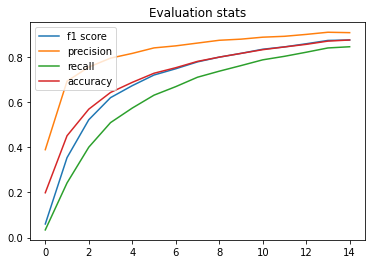

In [42]:
# plot metrics
pyplot.plot(history.history["f1_m"],  label="f1 score")
pyplot.plot(history.history["precision_m"], label="precision")
pyplot.plot(history.history["recall_m"], label="recall")
pyplot.plot(history.history['acc'] , label="accuracy")
pyplot.title('Evaluation stats')
pyplot.legend(loc="upper left")
pyplot.show()

## Saving Model

In [43]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [46]:
pwd

'/content/drive/My Drive/Deep_Learning /News_Classification'

In [45]:
ls

20_newsgroup/  glove.6B.zip  model.json     newsclassification.ipynb
glove.6B/      model.h5      news20.tar.gz


## Loading Saved model

In [49]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

In [53]:
loaded_model = tf.keras.models.model_from_json(loaded_model_json, custom_objects={"tf":tf})

In [54]:
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [56]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

## Predicting on new news text

In [58]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [59]:
test_texts = ["First of all as far as I know, only male homosexuality is explicitly mentioned in the bibles, so you're off the hook there, I think. In \
              any event, there are *plenty* of people in many denominations who \
              do not consider a person's sexual identification of gay/lesbian/bisexual \
              as an 'immoral lifestyle choice'",
     
             "The Washington Post said that the shooter never should have had a gun if \
             the gun laws worked. Kinnunen was a well-known troublemaker, had been declared \
             mentally incompetent to stand trial in Oklahoma. He had been convicted of a \
             number of felonies. Nonetheless, The Washington Post blamed Texas gun laws for \
             the tragedy, forgetting that Kinnunen could not get a gun legally in any U.S. \
             jurisdiction. So did some presidential candidates, including Joe Biden"
             ]
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [60]:
nn_output = loaded_model.predict(test_data)
print(nn_output)

[[6.1063219e-02 5.7951482e-05 1.0222716e-05 3.0973242e-06 2.4177272e-05
  1.6622842e-04 7.1790411e-05 2.1657646e-04 6.9167421e-05 3.0214125e-05
  3.5957628e-06 7.1229013e-05 2.8582149e-06 1.3277954e-03 1.7203348e-03
  7.4266422e-01 2.9028794e-03 1.7189523e-03 3.6049017e-03 1.8427047e-01]
 [1.5374733e-04 2.3685111e-08 4.3911101e-09 1.3235986e-08 2.8486380e-07
  1.4051847e-08 5.8174282e-06 7.4598094e-04 2.5187078e-04 3.1346509e-08
  1.1306389e-07 1.9340243e-04 7.5548942e-06 1.3296406e-05 2.7324582e-05
  5.3529197e-07 9.7339147e-01 1.8435380e-04 1.2375455e-02 1.2648696e-02]]


In [63]:
i=0
for idx in np.argmax(nn_output, axis=1):
    print("Category: ", index_to_label_dict[idx])
    print("text: " , test_texts[i])
    print("=====================================")
    i = i + 1

Category:  soc.religion.christian
text:  First of all as far as I know, only male homosexuality is explicitly mentioned in the bibles, so you're off the hook there, I think. In               any event, there are *plenty* of people in many denominations who               do not consider a person's sexual identification of gay/lesbian/bisexual               as an 'immoral lifestyle choice'
Category:  talk.politics.guns
text:  The Washington Post said that the shooter never should have had a gun if              the gun laws worked. Kinnunen was a well-known troublemaker, had been declared              mentally incompetent to stand trial in Oklahoma. He had been convicted of a              number of felonies. Nonetheless, The Washington Post blamed Texas gun laws for              the tragedy, forgetting that Kinnunen could not get a gun legally in any U.S.              jurisdiction. So did some presidential candidates, including Joe Biden
